<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/5a_descripcion_imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descripción de imágenes con atención
En este *notebook* programaremos un modelo de descripción de imágenes con redes neuronales con mecanismos de atención. El código está basado en el tutorial de Tensorflow [Image captioning with visual attention
](https://www.tensorflow.org/tutorials/text/image_captioning).

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import os
import json

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import get_file
from tensorflow.keras.layers import Dense, Embedding, GRU
from tensorflow.keras.layers import Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

TensorFlow 2.x selected.


## Conjunto de datos: COCO
Descargamos las imágenes y sus descripciones del conjunto de datos [_Common Objects in COntext_](http://cocodataset.org/) (COCO) usando la función `get_file` de Keras:

In [0]:
if not os.path.isfile('train2014.zip'):
  imagenes = get_file('train2014.zip',
                       origin = 'http://images.cocodataset.org/zips/train2014.zip',
                       cache_subdir=os.path.abspath('.'),
                       extract = True)

if not os.path.isfile('captions.zip'):
  descripciones = get_file('captions.zip',
                            origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                            cache_subdir=os.path.abspath('.'),
                            extract = True)

Cargamos en una lista las rutas de las imágenes y en otra sus correspondientes descripciones:


In [0]:
with open('./annotations/captions_train2014.json', 'r') as f:
    desc = json.load(f)

lista_desc = []
lista_rutas = []
for d in desc['annotations']:
    texto = '<start> ' + d['caption'] + ' <end>'
    ruta_imagen = './train2014/COCO_train2014_' + str(d['image_id']).zfill(12) + '.jpg'
    lista_rutas.append(ruta_imagen)
    lista_desc.append(texto)

Definimos un functor para el mapeo de datos. Este recibe la ruta de una imagen y su descripción y lee la imagen, la preprocesa y extrae características de la última capa convolucional del modelo NASNet pre-entrenado:

In [0]:
def procesa_imagen(ruta, desc):
  imagen = tf.io.read_file(ruta)
  imagen = tf.image.decode_jpeg(imagen, channels=3)
  imagen = tf.image.resize(imagen, (224, 224))
  imagen = preprocess_input(imagen)

  return imagen, desc

Asimismo, cada descripción se procesa por un analizador léxico y se transforma a una secuencia de vectores:

In [0]:
alex = Tokenizer(num_words=5000, oov_token="<unk>",
                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
alex.word_index['<pad>'] = 0
alex.index_word[0] = '<pad>'
alex.fit_on_texts(lista_desc)
sec_ent = alex.texts_to_sequences(lista_desc)
sec_max = max(len(s) for s in sec_ent)
sec_ent = pad_sequences(sec_ent, padding='post')

Se divide el conjunto en entrenamiento y validación:

In [0]:
rutas_ent, rutas_val, desc_ent, desc_val = train_test_split(lista_rutas,
                                                            sec_ent,
                                                            test_size = 0.9,
                                                            shuffle = True,
                                                            random_state = 123)

Ahora definimos nuestra tubería de datos para el entrenamiento con el funtor de mapeo `ProcesaImagen`.

In [0]:
ds_ent = tf.data.Dataset.from_tensor_slices((rutas_ent, desc_ent))
ds_ent = ds_ent.shuffle(10000)
ds_ent = ds_ent.map(procesa_imagen, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_ent = ds_ent.batch(32, drop_remainder=True)
ds_ent = ds_ent.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Muestra un par de ejemplos del conjunto de datos:

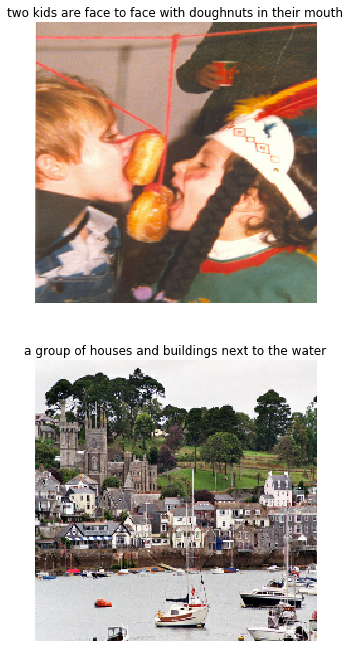

In [8]:
plt.figure(figsize=(30,30))
for i, (X, Y) in enumerate(ds_ent.take(2)):
  descripcion = []
  for p in range(1, Y.shape[1]):
    palabra = alex.index_word[Y[0,p].numpy()]
    if palabra == '<end>':
      break
    descripcion.append(palabra)

  img = X[0].numpy()
  img = (img - img.min()) / (img.max() - img.min())
  plt.subplot(5, 1, i + 1) 
  plt.imshow(img)
  plt.title(' '.join(descripcion))
  plt.axis('off')
plt.show()

## Definición de la red neuronal
La red neuronal que vamos a usar tiene una arquitectura secuencia a secuencia con atención de Bahdanau:

In [0]:
class AtencionBahdanau(tf.keras.Model):
  def __init__(self, n_neuronas):
    super(AtencionBahdanau, self).__init__()
    self.W = Dense(n_neuronas)
    self.U = Dense(n_neuronas)
    self.v = tf.keras.layers.Dense(1)

  def call(self, hc, hd):
    Uhc = self.U(hc)
    Whd = self.W(tf.expand_dims(hd, 1))
    puntajes = self.v(tf.nn.tanh(Uhc + Whd))
    alfas = tf.nn.softmax(puntajes, axis = 1)
    contexto = tf.reduce_sum(alfas * hc, axis = 1)

    return contexto, alfas

El codificador está compuesto por una sola capa densa con función de activación ReLU.

In [0]:
class Codificador(tf.keras.Model):
  def __init__(self, dim):
    super(Codificador, self).__init__()
    self.caract = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
    self.caract.trainable = False
    self.densa = Dense(dim)
  
  def call(self, x):
    x = self.caract(x)
    x = tf.reshape(x, (-1, x.shape[3]))
    x = self.densa(x)
    x = tf.nn.relu(x)
   
    return x

Por su parte, el decodificador está compuesto por una GRU con un mecanismo de atención de Bahdanau:

In [0]:
class Decodificador(tf.keras.Model):
  def __init__(self, dim, n_unidades, tam_vocab):
    super(Decodificador, self).__init__()
    self.n_unidades = n_unidades
    self.e = Embedding(tam_vocab, dim)
    self.gru = GRU(self.n_unidades,
                     return_sequences=True,
                     return_state=True)
    self.densa1 = Dense(self.n_unidades)
    self.densa2 = Dense(tam_vocab)
    self.atencion = AtencionBahdanau(self.n_unidades)

  def call(self, x, s, h):
    contexto, alfas = self.atencion(s, h)
    x = self.e(x)
    x = tf.concat([tf.expand_dims(contexto, 1), x], axis=-1)
    salida, hd = self.gru(x)
    x = self.densa1(salida)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.densa2(x)

    return x, hd, alfas

## Entrenamiento

In [0]:
def perdida_enmascarada(real, predicha, fn_perdida):
  mascara = tf.math.logical_not(tf.math.equal(real, 0))
  perdida = fn_perdida(real, predicha)

  mascara = tf.cast(mascara, dtype=perdida.dtype)
  perdida *= mascara

  return tf.reduce_mean(perdida)

Definimos la función que ajusta los pesos y sesgos de la red con un mini-lote de datos usando la función de pérdida y el optimizador dados:

In [0]:
@tf.function
def paso_ent(x, y, codificador, decodificador, fn_perdida, optimizador):
  perdida = 0
  
  hd = tf.zeros((y.shape[0], decodificador.n_unidades))
  entrada_dec = tf.expand_dims([alex.word_index['<start>']] * 32, 1)

  with tf.GradientTape() as cinta:
    caract_cnn = codificador(x)
    for i in range(1, y.shape[1]):
      prediccion, hd, alfas = decodificador(entrada_dec, caract_cnn, hd)
      perdida += perdida_enmascarada(y[:, i], prediccion, fn_perdida)
      entrada_dec = tf.expand_dims(y[:, i], 1)

  perdida_total = (perdida / int(y.shape[1]))
  var_ajustables = codificador.trainable_variables + decodificador.trainable_variables
  gradientes = cinta.gradient(perdida, var_ajustables)
  optimizador.apply_gradients(zip(gradientes, var_ajustables))

  return perdida, perdida_total

Definimos el optimizador (Adam), la función de pérdida (entropía cruzada categórica) y entrenamos por 20 épocas:

In [14]:
optimizador = Adam()
fn_perdida = SparseCategoricalCrossentropy(from_logits=True, reduction = 'none')
codificador = Codificador(256)
decodificador = Decodificador(256, 512, len(alex.word_index) + 1)
n_pasos = len(rutas_ent) // 32
hist_perdida_ent = []
for e in range(5):
  perdida_total = 0
  for (paso, (X, Y)) in enumerate(ds_ent):
    perdida_paso, perdida = paso_ent(X, Y, codificador, decodificador, 
                                     fn_perdida, optimizador)
  perdida_total += perdida
  hist_perdida_ent.append(perdida_total / n_pasos)
  print(u'Época {0:3d} Pérdida CCE = {1:6.8f}'.format(e + 1, perdida_total / n_pasos))

Época   1 Pérdida CCE = 0.00068238
Época   2 Pérdida CCE = 0.00059650
Época   3 Pérdida CCE = 0.00058647
Época   4 Pérdida CCE = 0.00057707
Época   5 Pérdida CCE = 0.00046033


## Gráfica de la pérdida 
Visualicemos la evolución de la pérdida de entropía cruzada categórica durante el entrenamiento:

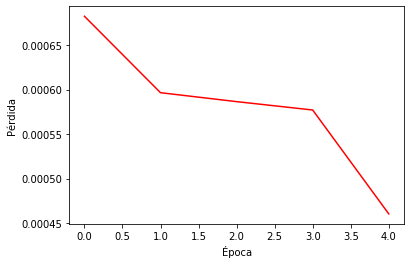

In [15]:
plt.plot(hist_perdida_ent, color='red', label='Entrenamiento')
plt.xlabel(u'Época')
plt.ylabel(u'Pérdida')
plt.show()

## Generación
Una vez entrenado nuestro modelo, podemos generar descripciones de imagenes. Primero, generaremos nuestro conjunto de datos de validación:

In [0]:
ds_val = tf.data.Dataset.from_tensor_slices((rutas_val, desc_val))
ds_val = ds_val.shuffle(len(rutas_val))
ds_val = ds_val.map(procesa_imagen,
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(1)
ds_val = ds_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Ahora generamos descripciones para estas imágenes

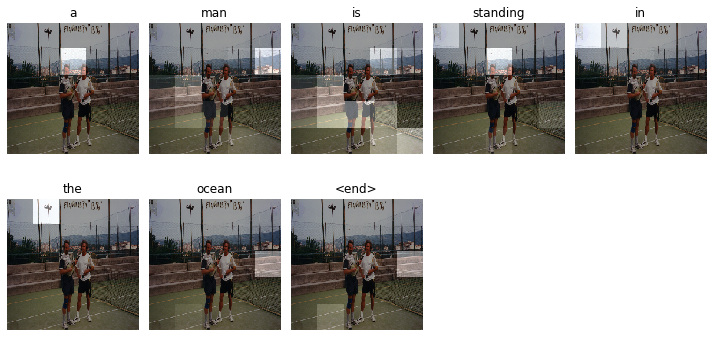

In [18]:
for i, (x, y) in enumerate(ds_val.take(1)):
  hd = tf.zeros((y.shape[0], decodificador.n_unidades))
  entrada_dec = tf.expand_dims([alex.word_index['<start>']], 1)
  caract_cnn = codificador(x)
  descripcion = []
  
  plt.figure(figsize=(10,10))
  for w in range(20):
    prediccion, hd, alfas = decodificador(entrada_dec, caract_cnn, hd)
    id_palabra = np.argmax(prediccion[0].numpy())
    palabra = alex.index_word[id_palabra]
    descripcion.append(palabra)

    atencion_visual = tf.reshape(alfas, (-1, ))
    img_atencion = np.resize(atencion_visual.numpy(), (5, 5))
    
    img_val = x[0].numpy()
    img_val = (img_val - img_val.min()) / (img_val.max() - img_val.min())

    plt.subplot(4, 5, w + 1)
    graf = plt.imshow(img_val)
    plt.imshow(img_atencion, cmap='gray', alpha=0.4, extent=graf.get_extent())
    plt.axis('off')
    plt.title(palabra)
    
    if palabra == '<end>':
      break

    entrada_dec = tf.expand_dims([id_palabra], 0)

  plt.tight_layout()

## Ejercicios
* Cambia el mecanismo de atención de Bahdanau al global, local o con retroalimentación de entrada de Luong y vuelve a entrenar y evaluar el modelo.
* Con la arquitectura definida en este *notebook*, entrena un modelo de traducción (ver el tutorial de Tensorflow [Neural machine translation with attention](https://www.tensorflow.org/tutorials/text/nmt_with_attention)).